# CNP/NP/ANP in Pytorch version
Modifications for Pytorch 1.0.1, python 3.7

## Open source license Notice
### (Attentive) Neural Processes for 1D regression (Tensorflow version)

https://github.com/deepmind/neural-processes
<br> Copyright 2019 Google LLC. Licensed under the Apache License 2.0 

### Reproduction for CNP/NP/ANP in pytorch version
 In this github.

In [1]:
import numpy as np

import torch
from torch.distributions import multivariate_normal, normal, kl
import torch.nn as nn

import collections, copy

import matplotlib.pyplot as plt
%matplotlib inline

### Generating train and test datasets
<br> Gaussian process with a gaussian kernel
<br> $k(x,x')= (sigma)^2 * exp(-\frac{|x-x'|^2}{2{l1}^2})$

In [2]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader:
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.6,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          l1_scale: Float; typical scale for kernel distance function.
          sigma_scale: Float; typical scale for variance.
          random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
              will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        super().__init__()
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._random_kernel_parameters = random_kernel_parameters
        self._testing = testing
        self._float_tensor = torch.FloatTensor

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
          xdata: Tensor of shape [B, num_total_points, x_size] with
              the values of the x-axis data.
          l1: Tensor of shape [B, y_size, x_size], the scale
              parameter of the Gaussian kernel.
          sigma_f: Tensor of shape [B, y_size], the magnitude
              of the std.
          sigma_noise: Float, std of the noise that we add for stability.

        Returns:
          The kernel, a float tensor of shape
          [B, y_size, num_total_points, num_total_points].
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        xdata1 = xdata.unsqueeze(1) # [B, 1, num_total_points, x_size]
        xdata2 = xdata.unsqueeze(2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2

        norm = torch.sum(norm, dim=-1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f**2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generation(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """
        num_context = torch.randint(3, self._max_num_context, [])
        
        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = (torch.arange(-2., 2., step=1. / 100).unsqueeze(0)).repeat(
                [self._batch_size, 1])
            x_values = x_values.unsqueeze(-1)
        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = torch.randint(0, self._max_num_context - num_context, [])
            num_total_points = num_context + num_target
            x_values = self._float_tensor(self._batch_size, num_total_points, self._x_size).uniform_(-2,2)

        # Set kernel parameters
        # Either choose a set of random parameters for the mini-batch
        if self._random_kernel_parameters:
            l1 = self._float_tensor(self._batch_size, self._y_size, self._x_size).uniform_(0.1, self._l1_scale)
            sigma_f = self._float_tensor(self._batch_size, self._y_size).uniform_(0.1, self._sigma_scale)
        # Or use the same fixed parameters for all mini-batches
        else:
            l1 = torch.ones([self._batch_size, self._y_size, self._x_size]) * self._l1_scale
            sigma_f = torch.ones([self._batch_size, self._y_size]) * self._sigma_scale

        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)
        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel.double()).float()

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = cholesky @ torch.randn([self._batch_size, self._y_size, num_total_points, 1])

        # [batch_size, num_total_points, y_size]
        y_values = (y_values.squeeze(3)).transpose(1,2)

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = torch.index_select(x_values, 1, idx[:num_context])
            context_y = torch.index_select(y_values, 1, idx[:num_context])

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]
            
          
        query = ((context_x, context_y), target_x)
        
        return NPRegressionDescription(
                query=query,
                target_y=target_y,
                num_total_points=target_x.shape[1],
                num_context_points=num_context)

In [3]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.

    Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
    """
    target_x, target_y = target_x.numpy(), target_y.numpy()
    context_x, context_y = context_x.numpy(), context_y.numpy()
    pred_y, std = pred_y.numpy(), std.numpy()
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=5)
    plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - std[0, :, 0],
      pred_y[0, :, 0] + std[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid(False)
    ax = plt.gca()
    plt.show()

# Plot 1-d GP Curves

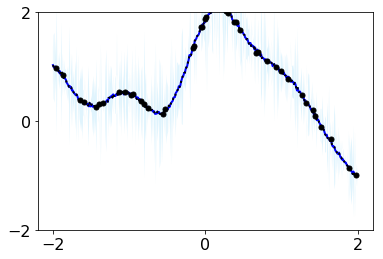

In [4]:
#torch.manual_seed(190429)
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
random_kernel_parameters=True #@param {type:"boolean"}

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generation()

(context_x, context_y), target_x = data_test.query
target_y = data_test.target_y
std_y = torch.randn(target_y.shape)*0.5
pred_y = data_test.target_y
plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_sizes):
        super().__init__()
        layers = []
        out_dim = input_size
        for i, size in enumerate(output_sizes[:-1]):
            in_dim = input_size if i == 0 else output_sizes[i-1]
            out_dim = size
            layers += [nn.Linear(in_dim, out_dim), nn.ReLU()]
        # Last layer without a ReLU
        layers += [nn.Linear(out_dim, output_sizes[-1])]
        self.mlp = nn.Sequential(*layers)
                   
    def forward(self, x):
        return self.mlp(x)

In [6]:
class DeterministicEncoder(nn.Module):
    """The Deterministic Encoder."""

    def __init__(self, input_size, output_sizes, attention):
        """(A)NP deterministic encoder.

        Args:
          input_size: raw input size = x_size + y_size
          output_sizes: An iterable containing the output sizes of the encoding MLP.
          attention: The attention module.
        """
        super().__init__()
        self._intput_size = input_size
        self._output_sizes = output_sizes
        self._attention = attention
        self._mlp = MLP(input_size, output_sizes)

    def forward(self, context_x, context_y, target_x):
        """Encodes the inputs into one representation.

        Args:
          context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
              task this corresponds to the x-values.
          context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
              task this corresponds to the y-values.
          target_x: Tensor of shape [B,target_observations,d_x]. 
              For this 1D regression task this corresponds to the x-values.

        Returns:
          The encoded representation. Tensor of shape [B,target_observations,d]
        """

        # Concatenate x and y along the filter axes
        encoder_input = torch.cat([context_x, context_y], dim=-1)

        # Pass final axis through MLP
        hidden = self._mlp(encoder_input)

        # Apply cross_attention
        hidden = self._attention(context_x, target_x, hidden)

        return hidden

In [7]:
class LatentEncoder(nn.Module):
    """The Latent Encoder."""

    def __init__(self, input_size, output_sizes, num_latents):
        """(A)NP latent encoder.

        Args:
          input_size: raw input size = x_size + y_size
          output_sizes: An iterable containing the output sizes of the encoding MLP.
          num_latents: The latent dimensionality.
        """
        super().__init__()
        self._input_size = input_size
        self._output_sizes = output_sizes
        self._num_latents = num_latents
        self._mlp = MLP(input_size, output_sizes)
        self._z_mlp = MLP(output_sizes[-1], [num_latents, num_latents*2])
        
    def forward(self, x, y):
        """Encodes the inputs into one representation.

        Args:
          x: Tensor of shape [B,observations,d_x]. For this 1D regression
              task this corresponds to the x-values.
          y: Tensor of shape [B,observations,d_y]. For this 1D regression
              task this corresponds to the y-values.

        Returns:
          A normal distribution over tensors of shape [B, num_latents]
        """

        # Concatenate x and y along the filter axes
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        hidden = self._mlp(encoder_input)

        # Aggregator: take the mean over all points
        hidden = torch.mean(hidden, dim=1)

        # Produce mu & sigma
        hidden = self._z_mlp(hidden)

        mu, log_sigma = torch.split(hidden, self._num_latents, dim=-1)

        # Compute sigma
        sigma = 0.1 + 0.9 * torch.sigmoid(log_sigma)
        
        dist = normal.Normal(mu, sigma)
        
        return dist, mu, sigma

In [8]:
class Decoder(nn.Module):
    """The Decoder."""

    def __init__(self, input_size, output_sizes):        
        """(A)NP decoder.

        Args:
          input_size: representation size + target_x size
          output_sizes: An iterable containing the output sizes of the decoder MLP 
              as defined in `basic.Linear`.
        """
        super().__init__()
        self._intput_size = input_size
        self._output_sizes = output_sizes
        self._mlp = MLP(input_size, output_sizes)
        self._half_final_size = int(output_sizes[-1]/2)
        self._softplus = nn.Softplus()

    def forward(self, representation, target_x):
        """Decodes the individual targets.

        Args:
          representation: The representation of the context for target predictions. 
              Tensor of shape [B,target_observations,?].
          target_x: The x locations for the target query.
              Tensor of shape [B,target_observations,d_x].

        Returns:
          dist: A multivariate Gaussian over the target points. A distribution over
              tensors of shape [B,target_observations,d_y].
          mu: The mean of the multivariate Gaussian.
              Tensor of shape [B,target_observations,d_x].
          sigma: The standard deviation of the multivariate Gaussian.
              Tensor of shape [B,target_observations,d_x].
        """
        # concatenate target_x and representation
        hidden = torch.cat([representation, target_x], dim=-1)

        # Pass final axis through MLP
        hidden = self._mlp(hidden)

        # Get the mean an the variance
        mu, log_sigma = torch.split(hidden, self._half_final_size, dim=-1)
        
        # Bound the variance
        sigma = 0.1 + 0.9 * self._softplus(log_sigma)
        
        # Get the distribution
        dist = normal.Normal(mu, sigma) #multivariate, but, diagonal covariance matrix

        return dist, mu, sigma

In [9]:
def uniform_attention(q, v):
    """Uniform attention. Equivalent to np.

    Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].

    Returns:
    tensor of shape [B,m,d_v].
    """
    total_points = q.shape[1]
    rep = torch.mean(v, dim=1, keepdim=True)  # [B,1,d_v]
    rep = rep.repeat([1, total_points, 1])
    return rep

def dot_product_attention(q, k, v, normalise):
    """Computes dot product attention.

    Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.

    Returns:
    tensor of shape [B,m,d_v].
    """
    d_k = q.shape[-1]
    scale = np.sqrt(d_k)
    unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
    weight_fn = torch.sigmoid
    if normalise:
        weight_fn = torch.nn.Softmax(dim=-1)

    weights = weight_fn(unnorm_weights)  # [B,m,n]
    rep = torch.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
    return rep

class MultiHeadedAttention(nn.Module):
    # refered from http://nlp.seas.harvard.edu/2018/04/03/attention.html
    def __init__(self, h, d_model):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([copy.deepcopy(nn.Linear(d_model, d_model, bias=False)) for _ in range(4)])
        self.attn = None
        self.reset_parameters()

    def reset_parameters(self):
        for l in self.linears:
            nn.init.normal_(l.weight, std=self.d_k**-0.5)
        
    def _attention(self, query, key, value):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
        p_attn = torch.softmax(scores, dim = -1)

        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value):

        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = self._attention(query, key, value)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [10]:
class Attention(nn.Module):
    """The Attention module."""

    def __init__(self, rep_type, input_size, output_sizes, att_type, normalise=True, num_heads=8):
        """Create attention module.

        Takes in context inputs, target inputs and
        representations of each context input/output pair
        to output an aggregated representation of the context data.
        Args:
          input_size: original x size
          rep: transformation to apply to contexts before computing attention. 
              One of: ['identity','mlp'].
          output_sizes: list of number of hidden units per layer of mlp. ## for key and query
              Used only if rep == 'mlp'.
          att_type: type of attention. One of the following:
              ['uniform','dot_product','multihead']
          scale: scale of attention.
          normalise: Boolean determining whether to:
              1. apply softmax to weights so that they sum to 1 across context pts or
              2. apply custom transformation to have weights in [0,1].
          num_heads: number of heads for multihead.
        """
        super().__init__()
        self._rep_type = rep_type

        if self._rep_type == 'mlp':
            self._mlp = MLP(input_size, output_sizes)
        self._output_sizes = output_sizes
        self._type = att_type
        self._normalise = normalise
        if self._type == 'multihead':
            self._num_heads = num_heads
            self._mha = MultiHeadedAttention(num_heads, output_sizes[-1])

    def forward(self, x1, x2, r):
        """Apply attention to create aggregated representation of r.

        Args:
          x1: tensor of shape [B,n1,d_x]. key
          x2: tensor of shape [B,n2,d_x]. query
          r: tensor of shape [B,n1,d]. value

        Returns:
          tensor of shape [B,n2,d]

        Raises:
          NameError: The argument for rep/type was invalid.
        """
        if self._rep_type == 'identity':
            k, q = (x1, x2)
        elif self._rep_type == 'mlp':
            # Pass through MLP
            k = self._mlp(x1)
            q = self._mlp(x2)
        else:
            raise NameError("'rep' not among ['identity','mlp']")

        if self._type == 'uniform':
            rep = uniform_attention(q, r)
        elif self._type == 'dot_product':
            rep = dot_product_attention(q, k, r, self._normalise)
        elif self._type == 'multihead':
            rep = self._mha(q, k, r)
        else:
            raise NameError(("'att_type' not among ['uniform','dot_product','multihead']"))

        return rep

In [11]:
class NeurlProcess(nn.Module):
    """The CNP/NP/ANP model."""

    def __init__(self, encoder_input_sizes, latent_encoder_output_sizes, num_latents,
                decoder_output_sizes, NP_type='CNP', 
                deterministic_encoder_output_sizes=None, 
                att_type='uniform', rep_type='identity'):
        """Initialises the model.

        Args:
          encoder_input_sizes: [x_size, y_size]
          latent_encoder_output_sizes: An iterable containing the sizes of hidden 
              layers of the latent encoder.
          num_latents: The latent dimensionality.
          decoder_output_sizes: An iterable containing the sizes of hidden layers of
              the decoder. The last element should correspond to d_y * 2
              (it encodes both mean and variance concatenated)
          use_deterministic_path: a boolean that indicates whether the deterministic
              encoder is used or not.
          deterministic_encoder_output_sizes: An iterable containing the sizes of 
              hidden layers of the deterministic encoder. The last one is the size 
              of the deterministic representation r.
          attention: The attention module used in the deterministic encoder.
              Only relevant when use_deterministic_path=True.
        """
        super().__init__()    
        
        # decoder_input_size : will be x_size + deterministic_encoder_size + latent_encoder_size
        decoder_input_size = encoder_input_sizes[0]
        self._NP_type = NP_type
        if (NP_type == 'CNP') or (NP_type == 'ANP'):
            #Set attention
            self.attention = Attention(rep_type, input_size=encoder_input_sizes[0], 
                                       output_sizes=[num_latents]*2, att_type=att_type)
            #Get deterministic_encoder
            self._deterministic_encoder = DeterministicEncoder(
                sum(encoder_input_sizes), deterministic_encoder_output_sizes, self.attention)
            decoder_input_size += deterministic_encoder_output_sizes[-1]
        if (NP_type == 'ANP') or (NP_type == 'NP'):
            self._latent_encoder = LatentEncoder(
                sum(encoder_input_sizes), latent_encoder_output_sizes, num_latents)
            decoder_input_size += num_latents
        
        self._decoder = Decoder(decoder_input_size, decoder_output_sizes)

    def sample_z(self, mu, sigma):
        """Reparametrization trick
        """
        eps = torch.rand(sigma.shape)
        return mu + torch.sqrt(sigma) * eps

    def _KL(self, mu, sigma, mup, sigmap):
        t = 2*torch.log(sigmap) - 2*torch.log(sigma) + (sigma**2)* (1/sigmap**2) + (1/sigmap**2)*((mu-mup)**2)
        return t*0.5
    
    def forward(self, query, num_targets, target_y=None):
        """Returns the predicted mean and variance at the target points.

        Args:
          query: Array containing ((context_x, context_y), target_x) where:
              context_x: Tensor of shape [B,num_contexts,d_x]. 
                  Contains the x values of the context points.
              context_y: Tensor of shape [B,num_contexts,d_y]. 
                  Contains the y values of the context points.
              target_x: Tensor of shape [B,num_targets,d_x]. 
                  Contains the x values of the target points.
          num_targets: Number of target points.
          target_y: The ground truth y values of the target y. 
              Tensor of shape [B,num_targets,d_y].

        Returns:
          log_p: The log_probability of the target_y given the predicted
              distribution. Tensor of shape [B,num_targets].
          mu: The mean of the predicted distribution. 
              Tensor of shape [B,num_targets,d_y].
          sigma: The variance of the predicted distribution.
              Tensor of shape [B,num_targets,d_y].
        """

        (context_x, context_y), target_x = query

        latent_rep = None
        prior = None
        posterior = None
        # Compute latent_rep from latent encoder
        if (self._NP_type == 'NP') or self._NP_type == 'ANP':            
            # Note that targets contain contexts by design.
            prior, prior_mu, prior_sigma = self._latent_encoder(context_x, context_y)
            if target_y is None:
                # For testing, when target_y unavailable, use contexts for latent encoder.
                latent_rep = self.sample_z(prior_mu, prior_sigma) 
                #latent_rep = prior.sample()
                #Note: Using prior.sample() will return a just constant            
            else:                
                # For training, when target_y is available, use targets for latent encoder.
                posterior, posterior_mu, posterior_sigma = self._latent_encoder(target_x, target_y)
                latent_rep = self.sample_z(posterior_mu, posterior_sigma)
                #latent_rep = posterior.sample()

            latent_rep = (latent_rep.unsqueeze(1)).repeat([1, num_targets, 1])
        representation = None
        if self._NP_type == 'CNP':
            deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                          target_x)
            representation = deterministic_rep
        elif self._NP_type == 'ANP':
            deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                          target_x)
            representation = deterministic_rep
            representation = torch.cat([deterministic_rep, latent_rep], dim=-1)
        else:
            # For NP, the deterministric representations are not used
            representation = latent_rep

        dist, mu, sigma = self._decoder(representation, target_x)

        # If we want to calculate the log_prob for training we will make use of the
        # target_y. At test time the target_y is not available so we return None.
        if target_y is not None:
            log_p = dist.log_prob(target_y)
            log_p = log_p.squeeze(-1)
            loss = None
            if self._NP_type == 'CNP':
                loss = -torch.mean(log_p)
            else:
                #posterior = self._latent_encoder(target_x, target_y)
                dkl = torch.sum(self._KL(posterior_mu, posterior_sigma, prior_mu, prior_sigma),
                  #kl.kl_divergence(posterior, prior), 
                  dim=-1, keepdim=True)

                dkl = dkl.repeat([1, num_targets])

                loss = - torch.mean(log_p - dkl / num_targets)

        else:
            log_p = None
            loss = None

        return mu, sigma, log_p, loss

In [12]:
def run_epoch(data_train, model, optimizer):
    "Standard Training and Logging Function"

    total_loss = 0    
    optimizer.zero_grad()
    _, _, _, loss = model.forward(data_train.query, data_train.num_total_points, data_train.target_y)        
    
    loss.backward()
    optimizer.step()
    

    total_loss += loss.item()
    return total_loss

Iteration: 0, loss: 0.9272059798240662


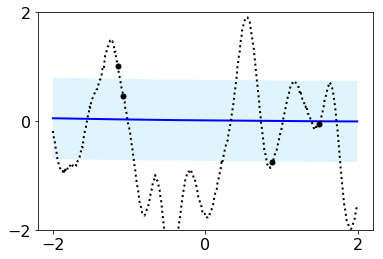

Iteration: 10000, loss: -0.29619061946868896


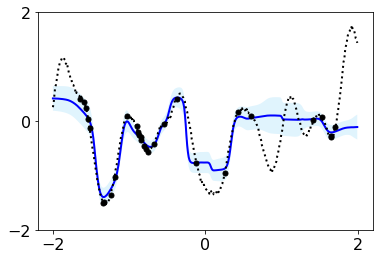

Iteration: 20000, loss: 1.1506561040878296


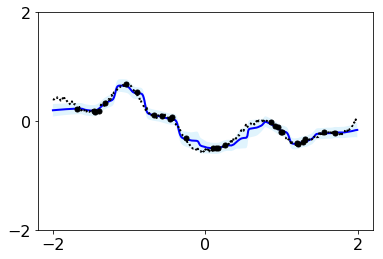

Iteration: 30000, loss: -1.04103684425354


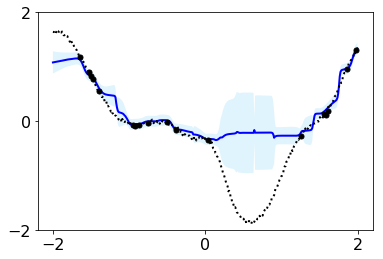

Iteration: 40000, loss: -1.2700605392456055


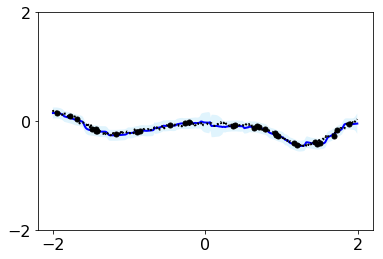

Iteration: 50000, loss: -1.265988826751709


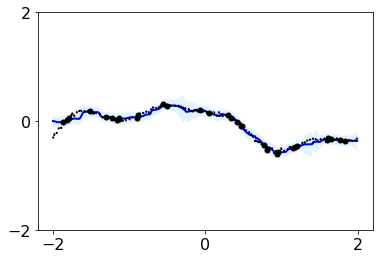

Iteration: 60000, loss: -0.6996220946311951


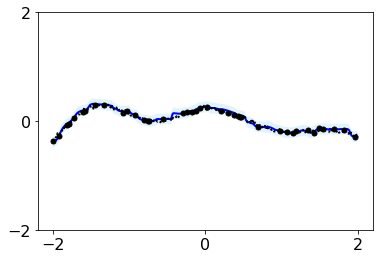

Iteration: 70000, loss: -1.3164433240890503


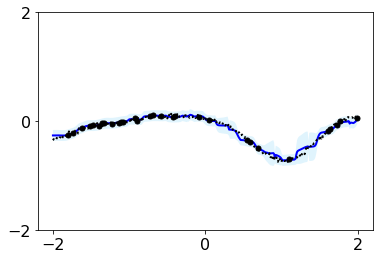

Iteration: 80000, loss: -1.2881931066513062


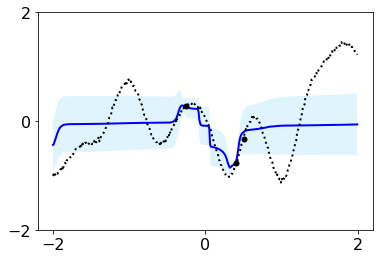

Iteration: 90000, loss: -1.2015272378921509


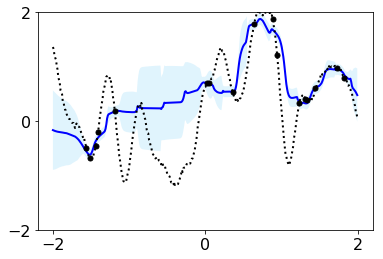

In [13]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'CNP' #@param ['CNP','NP','ANP']
random_kernel_parameters=True #@param {type:"boolean"}

ATTENTION_TYPE = None #@param ['uniform','dot_product','multihead']
REP_TYPE = None #@param ['identity','mlp'] for key&query embedding

if MODEL_TYPE == 'CNP':
    ATTENTION_TYPE = 'multihead' #'uniform'
    REP_TYPE = 'mlp' #'identity'
elif MODEL_TYPE == 'ANP':
    ATTENTION_TYPE = 'multihead' 
    REP_TYPE = 'mlp'

# Train dataset
dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)


# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_input_sizes = [1, 1]
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]

#encoder_input_sizes, latent_encoder_output_sizes, num_latents,
#                decoder_output_sizes, NP_type='CNP', 
#                deterministic_encoder_output_sizes=None, 
#                att_type='uniform', rep_type='identity'
model = NeurlProcess(encoder_input_sizes, latent_encoder_output_sizes, num_latents,
                     decoder_output_sizes, MODEL_TYPE, 
                     deterministic_encoder_output_sizes, 
                     att_type=ATTENTION_TYPE, rep_type=REP_TYPE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #For NP, please use 1e-3


for epoch in range(TRAINING_ITERATIONS): #TRAINING_ITERATIONS
    torch.manual_seed(190501+epoch) #for fair comparison
    data_train = dataset_train.generation()
    model.train()
    loss_value = run_epoch(data_train, model, optimizer)
    if epoch % PLOT_AFTER == 0:
        print('Iteration: {}, loss: {}'.format(epoch, loss_value))
        model.eval()
        torch.manual_seed(1905+epoch) #for fair comparison
        data_test = dataset_test.generation()
        pred_y, std_y, _, _ = model(data_test.query, data_test.num_total_points)
        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y
        plot_functions(target_x.detach(), target_y.detach(), context_x.detach(), context_y.detach(), pred_y.detach(), std_y.detach())

# Evalutation - RMSE

In [14]:
TEST_ITERATION = 10
TEST_GET_SAMPLES = 100
mse = nn.MSELoss()
Total_loss = 0
for epoch in range(TEST_ITERATION): #TRAINING_ITERATIONS
    model.eval()
    torch.manual_seed(2019+epoch) #for fair comparison
    data_test = dataset_test.generation()
    pred_y_avg = 0
    std_y = None
    for it in range(TEST_GET_SAMPLES):
        pred_y, std_y, _, _ = model(data_test.query, data_test.num_total_points, None)
        pred_y_avg = pred_y_avg + 1/(it+2) * (pred_y - pred_y_avg)
    pred_y = pred_y_avg
    #(context_x, context_y), target_x = data_test.query
    target_y = data_test.target_y
    #plot_functions(target_x.detach(), target_y.detach(), context_x.detach(), context_y.detach(), pred_y.detach(), std_y.detach())
    Total_loss += torch.sqrt(mse(pred_y, target_y)).item()
print('Average of RMSE of {}_{}_{}: {}'.format(
    MODEL_TYPE, ATTENTION_TYPE, REP_TYPE, Total_loss/TEST_ITERATION))

Average of RMSE of CNP_multihead_mlp: 0.1621706672012806


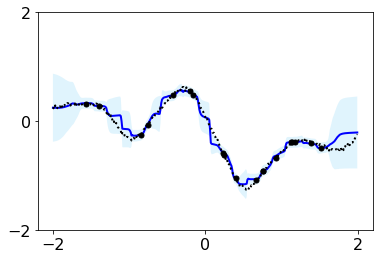

In [15]:
torch.manual_seed(20190501) #for fair comparison
data_test = dataset_test.generation()
(context_x, context_y), target_x = data_test.query
target_y = data_test.target_y
pred_y, std_y, _, _ = model(data_test.query, data_test.num_total_points, None)
plot_functions(target_x.detach(), target_y.detach(), context_x.detach(), context_y.detach(), pred_y.detach(), std_y.detach())

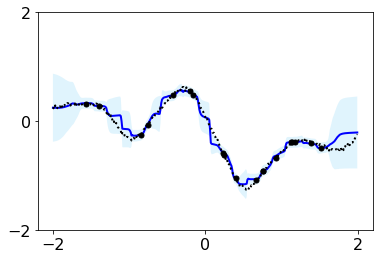

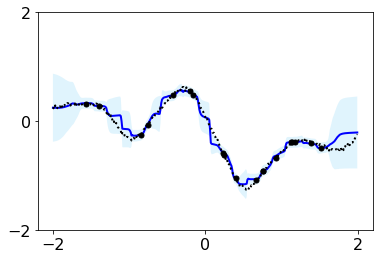

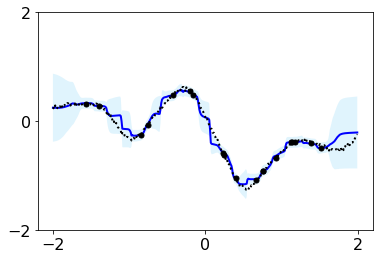

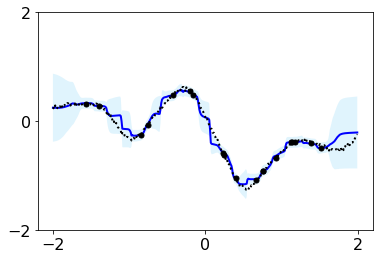

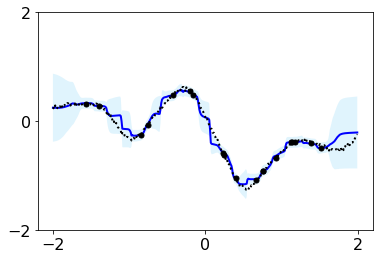

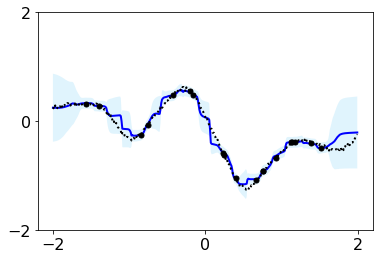

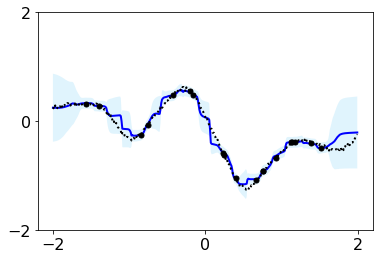

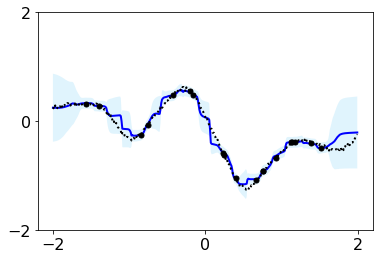

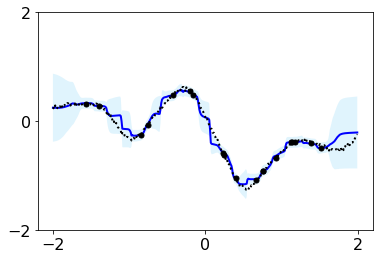

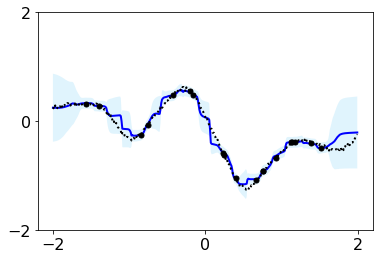

In [16]:
for i in range(10):
    torch.manual_seed(20190501+i)
    pred_y, std_y, _, _ = model(data_test.query, data_test.num_total_points)
    plot_functions(target_x.detach(), target_y.detach(), context_x.detach(), context_y.detach(), pred_y.detach(), std_y.detach())